In [106]:
import serial
import time
import csv
import os 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

# use with pwm_enc_will_this_work.ino
# 0.5 to 6 Hz linear chirp in 10s    N= 100000

In [126]:
t = []
RPM = []
V1 = []
V5 =[]
Encoder = []
N = 10000

try:
    ser = serial.Serial('/dev/tty.usbmodem56064601')
    ser.flushInput()

    # sum will treat Boolean True as a 1, False as a 0
    n = sum(os.path.isfile(name) for name in os.listdir('.'))
    file_name = "Encoder_data_%s.cvs" % n 
    print(file_name)


    for jj in np.arange(N):
        ser_byte = ser.readline()
        #print(ser_byte)
        decoded_bytes = ser_byte.decode('ascii').split(',')
        #print(decoded_bytes)
        dt = float(decoded_bytes[0])
        dRPM = float(decoded_bytes[1])
        dV1 = float(decoded_bytes[2])
        dV5 = float(decoded_bytes[3])
        dEncoder = float(decoded_bytes[4])

        t.append(dt)
        RPM.append(dRPM)
        V1.append(dV1)
        V5.append(dV5)
        Encoder.append(dEncoder)

        with open(file_name, "a+", newline='') as file:
          writer = csv.writer(file, delimiter=',')
          writer.writerow([dt, dRPM, dV1, dV5, dEncoder])
except:
    try:
        with open('Encoder_data_20.cvs', 'r') as file:
            reader = csv.reader(file)   
            for row in reader:
                t.append(float(row[0]))
                RPM.append(float(row[1]))
                V1.append(float(row[2]))
                V5.append(float(row[3]))
                Encoder.append(float(row[4]))
        print("Loaded recorded data")
    except:
        print("No data")

t = np.array(t)
t -= t[0]    

Loaded recorded data


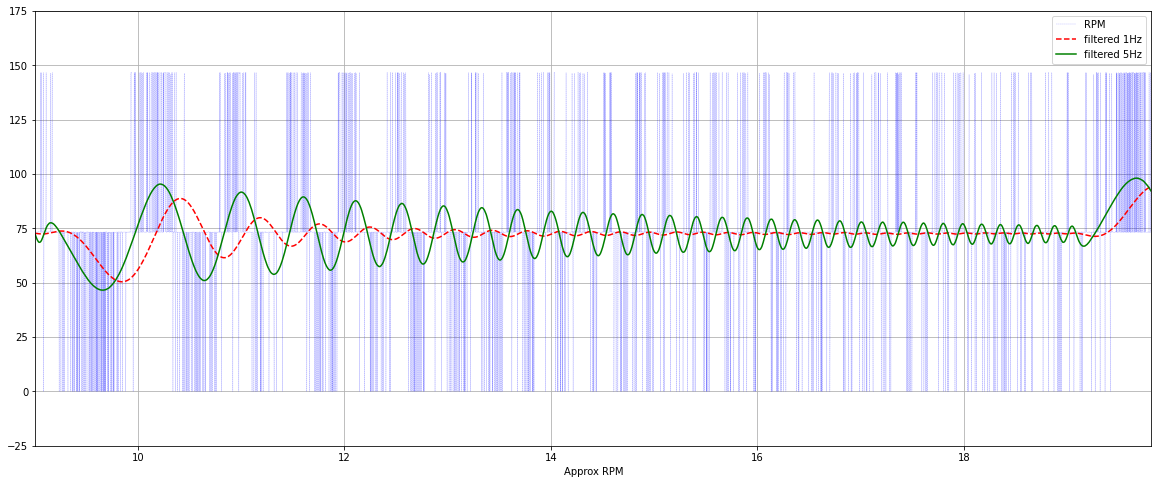

In [132]:
# parts to plot
Nlow = 4500
Nhigh = N-100 

fig, ax = plt.subplots()
ax.plot(t[Nlow:Nhigh],RPM[Nlow:Nhigh],'b:',lw=0.25)
ax.plot(t[Nlow:Nhigh],V1[Nlow:Nhigh],'r--')
ax.plot(t[Nlow:Nhigh],V5[Nlow:Nhigh],'g-')
ax.set_xlim(t[Nlow], t[Nhigh])
ax.set_ylim(-25, 175)
ax.set_xlabel('Time [s]')
ax.set_xlabel('Approx RPM')
plt.legend(['RPM','filtered 1Hz','filtered 5Hz'])
plt.grid()
plt.show()

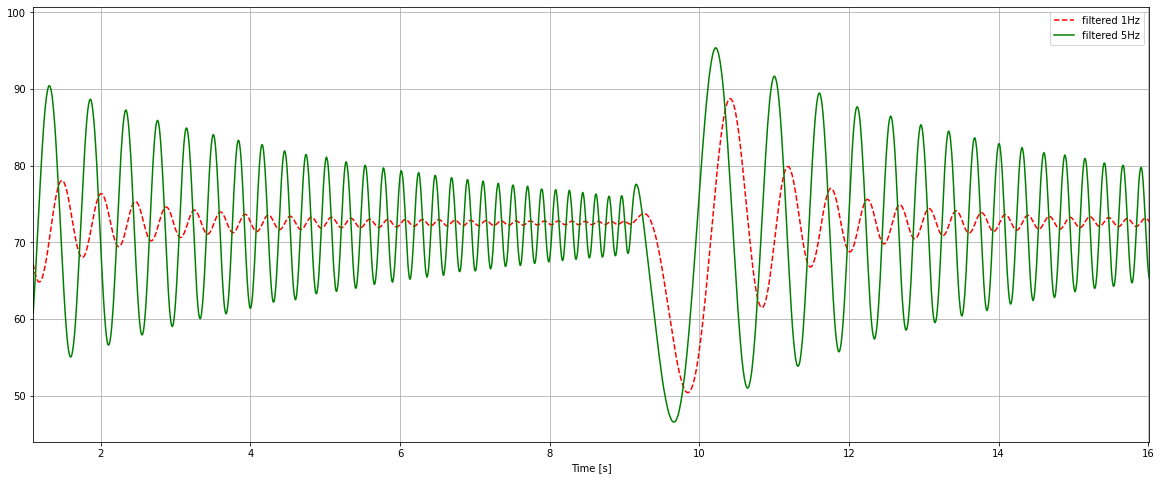

In [133]:
fig, ax = plt.subplots()

ax.plot(t,V1,'r--')
ax.plot(t,V5,'g-')

Nlow = 550
Nhigh = 8000
ax.set_xlim(t[Nlow], t[Nhigh])

#ax.set_ylim(40, 120)
plt.legend(['filtered 1Hz','filtered 5Hz'])
ax.set_xlabel('Time [s]')
plt.grid()
plt.show()

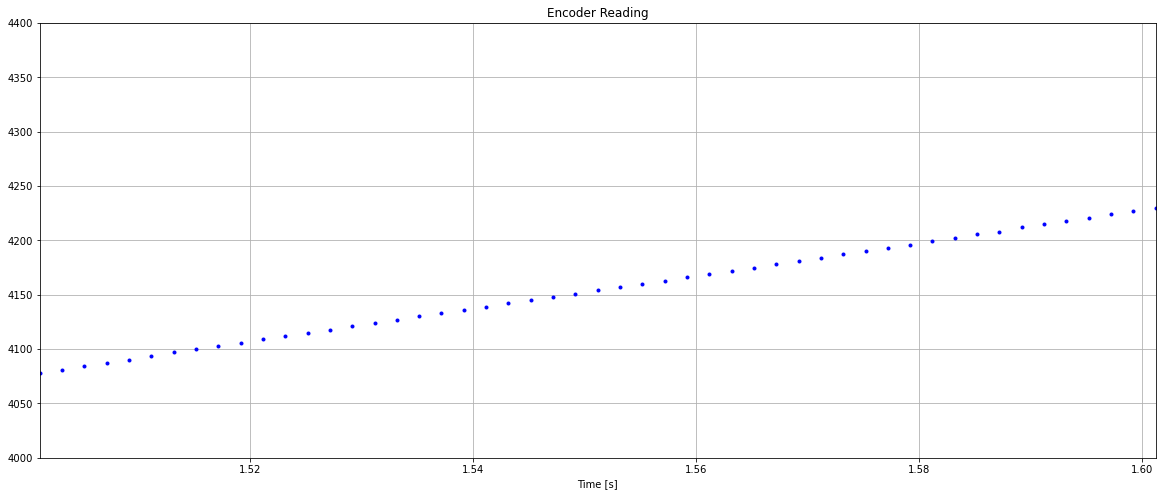

In [134]:
# Check Encoder
fig, ax = plt.subplots()

ax.plot(t,Encoder,'b.')

Nlow = 750
Nhigh = 800
ax.set_ylim(4000, 4400)
ax.set_xlim(t[Nlow], t[Nhigh])
ax.set_xlabel('Time [s]')
plt.title('Encoder Reading')
plt.grid()
plt.show()

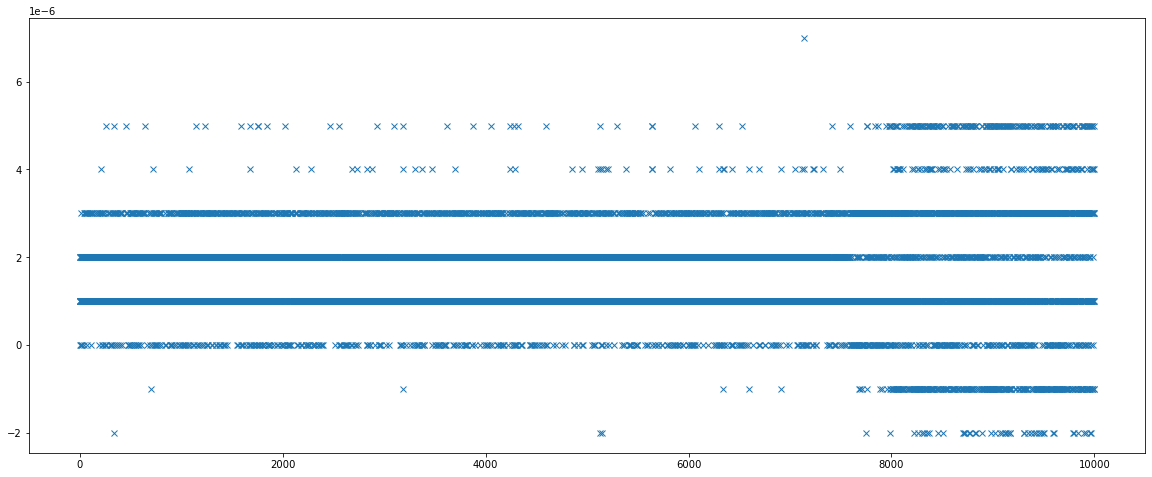

In [135]:
# check timing
printtime = 2000e-6 # in teensy code
plt.plot(np.diff(t) - printtime,'x')
ax.set_ylabel('Delta Time error')
ax.set_xlabel('Time [s]')
plt.show()